In [1]:
import numpy as np
import nibabel as nib
from dipy.segment.mask import median_otsu
from matplotlib import pyplot as plt
from tqdm import tqdm
import pickle
from scipy.optimize import least_squares

# nii_data

In [ ]:
nii_gz_path = 'C:/Users/panag/Desktop/Test/mgh_1001/diff/preproc/mri/diff_preproc.nii.gz'
nii_data  = nib.load(nii_gz_path).get_fdata()

In [ ]:
np.save('nii_data.npy', nii_data)

In [2]:
nii_data = np.load('nii_data.npy')

In [3]:
nii_data.shape

(140, 140, 96, 552)

# direction_vectors

In [4]:
direction_vectors_path = 'C:/Users/panag/Desktop/Test/mgh_1001/diff/preproc/bvecs_moco_norm.txt'
direction_vectors = np.genfromtxt(direction_vectors_path)

In [5]:
direction_vectors.shape

(552, 3)

# b_values

In [6]:
b_values_path = 'C:/Users/panag/Desktop/Test/mgh_1001/diff/preproc/bvals.txt'
b_values = np.genfromtxt(b_values_path)
b_values[(b_values > 9_900) & (b_values < 10_100)] = 10_000
b_values /= 1_000.0

In [7]:
unique_b_values, unique_b_values_counts = np.unique(b_values, return_counts=True)

In [8]:
unique_b_values, unique_b_values_counts

(array([ 0.,  1.,  3.,  5., 10.]),
 array([ 40,  64,  64, 128, 256], dtype=int64))

In [9]:
b_value_to_indices = {b_value: np.where(b_values == b_value)[0] for b_value in unique_b_values}

# nii_masked_data

In [10]:
nii_data_masked, mask = median_otsu(nii_data, vol_idx=b_value_to_indices[0])

In [11]:
nii_data_masked.shape, mask.shape

((140, 140, 96, 552), (140, 140, 96))

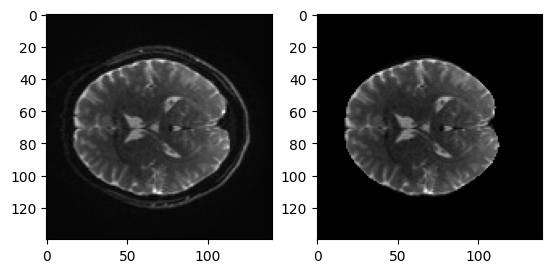

In [12]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(nii_data[:,:,50,b_value_to_indices[0][0]], cmap='gray')
ax[1].imshow(nii_data_masked[:,:,50,b_value_to_indices[0][0]], cmap='gray')
plt.show()

# masked signal range analysis

b-value: 0.0, min: -266.8165588378906, max: 5897.9404296875
b-value: 1.0, min: -58.791419982910156, max: 1190.9769287109375
b-value: 3.0, min: -34.31354904174805, max: 568.5299682617188
b-value: 5.0, min: -35.877254486083984, max: 497.3490905761719
b-value: 10.0, min: -33.32368469238281, max: 421.12225341796875
b-value: ALL, min: -266.8165588378906, max: 5897.9404296875


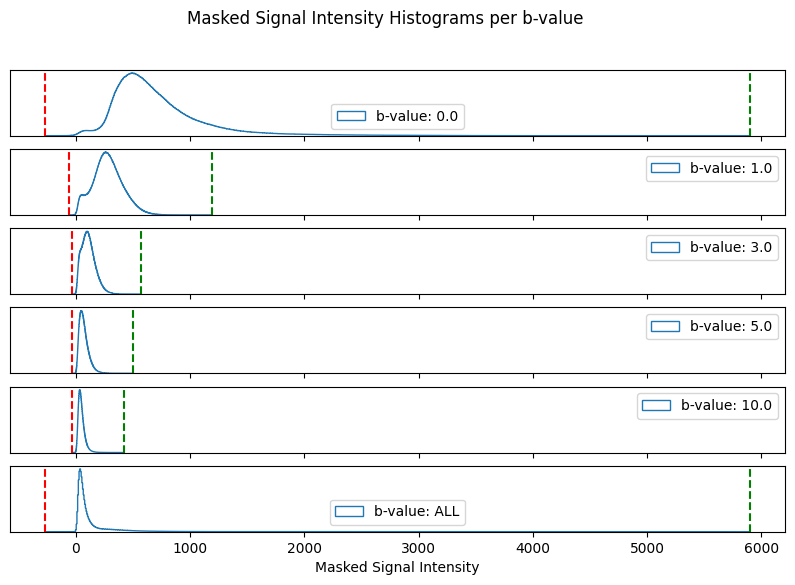

In [13]:
fig, ax = plt.subplots(1 + len(b_value_to_indices), 1, figsize=(10, 6), sharex=True)
fig.suptitle('Masked Signal Intensity Histograms per b-value')

for i, (b_value, indices) in enumerate(b_value_to_indices.items()):
    
    S = nii_data_masked[:, :, :, indices]
    min_val, max_val = np.min(S), np.max(S)    
    print(f'b-value: {b_value}, min: {min_val}, max: {max_val}')    
    
    ax[i].hist(S[S != 0.0].flatten(), bins=1000, histtype='step', label=f'b-value: {b_value}')
    ax[i].legend()
    ax[i].yaxis.set_visible(False)
    ax[i].axvline(min_val, color='r', linestyle='--')
    ax[i].axvline(max_val, color='g', linestyle='--')


min_val, max_val = np.min(nii_data_masked), np.max(nii_data_masked)
print(f'b-value: ALL, min: {min_val}, max: {max_val}')

ax[-1].hist(nii_data_masked[nii_data_masked != 0.0].flatten(), bins=1000, histtype='step', label=f'b-value: ALL')
ax[-1].legend()
ax[-1].yaxis.set_visible(False)
ax[-1].axvline(min_val, color='r', linestyle='--')
ax[-1].axvline(max_val, color='g', linestyle='--')


ax[-1].set_xlabel('Masked Signal Intensity')
plt.savefig('masked signal intensity histograms per b-value.png')
plt.show()

# linear least squares

$$
\begin{align*}
& S = S_0 \exp(- \ b \ g \ D \ g^T) \\
& \ln ( S / S_0 ) = - \ b \ g \ D \ g^T \\
& \ln ( S / S_0 ) = - \ b \ 
\begin{bmatrix}
g_0 & g_1 & g_2
\end{bmatrix} \ 
\begin{bmatrix}
D_{0,0} & D_{0,1} & D_{0,2} \\
D_{0,1} & D_{1,1} & D_{1,2} \\
D_{0,2} & D_{1,2} & D_{2,2} \\
\end{bmatrix} \ 
\begin{bmatrix}
g_0 \\ g_1 \\ g_2
\end{bmatrix} \\
& \ln ( S / S_0 ) = - \ b \ 
\begin{bmatrix}
g_0 & g_1 & g_2
\end{bmatrix} \
\begin{bmatrix}
g_0 D_{0,0} + g_1 D_{0,1} + g_2 D_{0,2} \\
g_0 D_{0,1} + g_1 D_{1,1} + g_2 D_{1,2} \\
g_0 D_{0,2} + g_1 D_{1,2} + g_2 D_{2,2} \\
\end{bmatrix} \\
& \ln ( S / S_0 ) = - \ b \ ( \ 
g_0 ( g_0 D_{0,0} + g_1 D_{0,1} + g_2 D_{0,2} ) +
g_1 ( g_0 D_{0,1} + g_1 D_{1,1} + g_2 D_{1,2} ) +
g_2 ( g_0 D_{0,2} + g_1 D_{1,2} + g_2 D_{2,2} )
\ ) \\
& \ln ( S / S_0 ) = - \ b \ ( \ 
g_0 g_0 D_{0,0} + g_0 g_1 D_{0,1} + g_0 g_2 D_{0,2} +
g_1 g_0 D_{0,1} + g_1 g_1 D_{1,1} + g_1 g_2 D_{1,2} +
g_2 g_0 D_{0,2} + g_2 g_1 D_{1,2} + g_2 g_2 D_{2,2}
\ ) \\
& \ln ( S / S_0 ) = - \ b \ ( \ 
g_0 g_0 D_{0,0} + 2 g_0 g_1 D_{0,1} + 2 g_0 g_2 D_{0,2} +
g_1 g_1 D_{1,1} + 2 g_1 g_2 D_{1,2} + g_2 g_2 D_{2,2}
\ ) \\
& \ln ( S / S_0 ) = 
\begin{bmatrix}
D_{0,0} & D_{0,1} & D_{0,2} & D_{1,1} & D_{1,2} & D_{2,2} \\
\end{bmatrix} \
(-b) \
\begin{bmatrix}
g_0 g_0 \\ 2 g_0 g_1 \\ 2 b g_0 g_2 \\
g_1 g_1 \\ 2 g_1 g_2 \\ g_2 g_2 \\
\end{bmatrix}
\\
\end{align*}
$$

In [14]:
b_value = 1.0
epsilon = 1e-8

linear_lstsq_results = {}
linear_errors = []

# create a progress bar
pbar = tqdm(total=np.sum(mask))

# loop over unmasked voxels
for i in range(nii_data.shape[0]):
    for j in range(nii_data.shape[1]):
        for k in range(nii_data.shape[2]):
            if mask[i,j,k]:
                
                # calculate y
                S = nii_data[i, j, k, b_value_to_indices[b_value]]
                S0 = nii_data[i, j, k, b_value_to_indices[0.0]].mean()

                # avoid division by zero or negative values
                if abs(S0) < epsilon or np.any(S / S0 < epsilon):
                    pbar.update()
                    continue
                
                y = np.log(S / S0)
                
                # calculate X
                g = direction_vectors[b_value_to_indices[b_value], :]
                X = - b_value * np.array([g[:,0]**2, 2*g[:,0]*g[:,1], 2*g[:,0]*g[:,2], 
                                          g[:,1]**2, 2*g[:,1]*g[:,2], g[:,2]**2]).T
                
                # calculate lstsq
                params = np.linalg.lstsq(X, y, rcond=None)[0]
                
                # reconstruct tensor
                D = np.array([[params[0], params[1], params[2]],
                              [params[1], params[3], params[4]],
                              [params[2], params[4], params[5]]])
                
                # try Cholesky decomposition
                try:
                    _ = np.linalg.cholesky(D)
                except:
                    pbar.update()
                    continue

                linear_lstsq_results[(i,j,k)] = D
                linear_errors.append( 
                    np.mean(
                        (S0 * np.exp(X @ params) - S)**2
                    )
                )
                
                pbar.update()

pbar.close()

print(f'Average error: {np.mean(linear_errors)} +- {np.std(linear_errors)}')

100%|██████████| 345666/345666 [00:42<00:00, 8223.41it/s] 

Average error: 774.1470429749435 +- 403.65130430735564


In [15]:
np.sum(mask), len(linear_lstsq_results), np.sum(mask) - len(linear_lstsq_results)

(345666, 334194, 11472)

In [16]:
with open('linear_lstsq_results.pkl', 'wb') as f:
    pickle.dump(linear_lstsq_results, f)

In [17]:
with open('linear_lstsq_results.pkl', 'rb') as f:
    linear_lstsq_results = pickle.load(f)

# non linear least squares

In [18]:
def loss(params, X, S, S0):
    return S0 * np.exp(X @ params) - S

b_value = 1.0

non_linear_lstsq_results = {}
non_linear_errors = []

# create a progress bar
pbar = tqdm(total=np.sum(mask))

# loop over unmasked voxels
for i in range(nii_data.shape[0]):
    for j in range(nii_data.shape[1]):
        for k in range(nii_data.shape[2]):
            if mask[i,j,k]:
                
                # calculate y
                S = nii_data[i, j, k, b_value_to_indices[b_value]]                    
                S0 = nii_data[i, j, k, b_value_to_indices[0.0]].mean()

                # calculate X
                g = direction_vectors[b_value_to_indices[b_value], :]
                X = - b_value * np.array([g[:,0]**2, 2*g[:,0]*g[:,1], 2*g[:,0]*g[:,2], 
                                          g[:,1]**2, 2*g[:,1]*g[:,2], g[:,2]**2]).T
                
                # randomly initialize params in [-0.5, 0.5]
                params = np.random.rand(6) - 0.5

                # minimize the loss function
                result = least_squares(loss, params, args=(X, S, S0))

                # reconstruct tensor
                D = np.array([[result.x[0], result.x[1], result.x[2]],
                            [result.x[1], result.x[3], result.x[4]],
                            [result.x[2], result.x[4], result.x[5]]])
                
                # try Cholesky decomposition
                try:
                    _ = np.linalg.cholesky(D)
                except:
                    pbar.update()
                    continue
                
                non_linear_lstsq_results[(i,j,k)] = D
                non_linear_errors.append( 
                    np.mean(
                        (S0 * np.exp(X @ result.x) - S)**2
                    )
                )
                
                pbar.update()

pbar.close()

print(f'Average residual: {np.mean(non_linear_errors)} +- {np.std(non_linear_errors)}')

100%|██████████| 345666/345666 [10:10<00:00, 566.06it/s]

Average residual: 760.2269227915585 +- 391.129395233511


In [19]:
np.sum(mask), len(non_linear_lstsq_results), np.sum(mask) - len(non_linear_lstsq_results)

(345666, 338645, 7021)

In [20]:
with open('non_linear_lstsq_results.pkl', 'wb') as f:
    pickle.dump(non_linear_lstsq_results, f)

In [21]:
with open('non_linear_lstsq_results.pkl', 'rb') as f:
    non_linear_lstsq_results = pickle.load(f)

# linear vs non-linear

In [22]:
common_count = 0
equal_common_count = 0

# create a progress bar
pbar = tqdm(total=np.sum(mask))

# loop over unmasked voxels
for i in range(nii_data.shape[0]):
    for j in range(nii_data.shape[1]):
        for k in range(nii_data.shape[2]):
            if mask[i,j,k]:

                if (i,j,k) in linear_lstsq_results and (i,j,k) in non_linear_lstsq_results:
                    common_count += 1
                    if np.allclose(linear_lstsq_results[(i,j,k)], non_linear_lstsq_results[(i,j,k)], rtol=1e-3, atol=1e-3):
                        equal_common_count += 1
                
                pbar.update()
pbar.close()

100%|██████████| 345666/345666 [00:09<00:00, 35286.75it/s]


In [23]:
equal_common_count, common_count, np.sum(mask)

(6005, 333757, 345666)

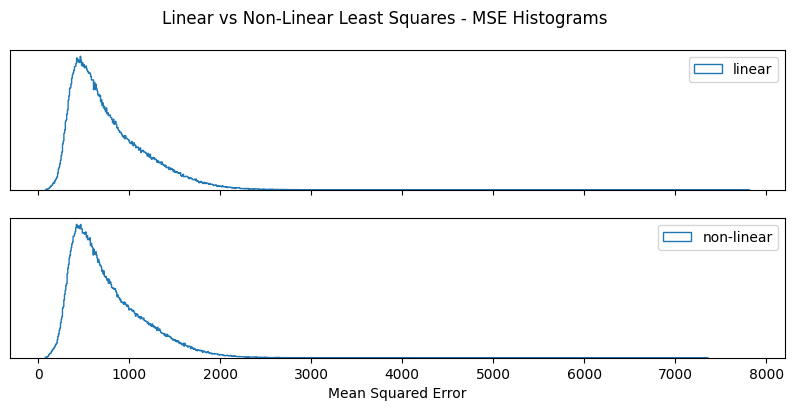

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
fig.suptitle('Linear vs Non-Linear Least Squares - MSE Histograms')

ax[0].hist(np.array(linear_errors), bins=1000, histtype='step', label='linear')
ax[0].legend()
ax[0].yaxis.set_visible(False)

ax[1].hist(np.array(non_linear_errors), bins=1000, histtype='step', label='non-linear')
ax[1].legend()
ax[1].yaxis.set_visible(False)

ax[-1].set_xlabel('Mean Squared Error')
plt.savefig('linear vs non-linear least squares - MSE histograms.png')
plt.show()